In [3]:
import xarray as xr

In [4]:
ds = xr.open_dataset("../data/raw_output/lagrangian_particles.nc")
nanosec_per_sec = 1e9
ds["time_in_seconds"] = ds.time.astype("float") / nanosec_per_sec
ds = ds.assign_coords(
    {
        "time_in_seconds":
        xr.DataArray(ds.time.astype("float")/nanosec_per_sec, dims=("time",))
    }
)

# Calculate the standard deviation of z at each time
ds['z_std'] = ds['z'].std(dim='particle_id')


In [6]:
def extend_x(ds):
    """
    Extends the x values of particles once they reach 5 for the purposes of plotting.
        """
    #create copy of ds to not mess it up
    ds_c = ds.copy()
    x_original = ds.x.copy().values
    nt = len(ds_c.time_in_seconds)
    # Loop over all particle_ids
    for i,p in enumerate(ds_c['particle_id'].values):
        for j,t in enumerate(ds_c.time_in_seconds.values[1:], start=1):
            x_cur = x_original[j,i]
            x_prev = x_original[j-1,i]
            diff = x_cur - x_prev
            if diff > 5:
               ds_c.x.values[j:nt,i] = ds_c.x.values[j:nt,i] - 10
            elif diff < -5:
                ds_c.x.values[j:nt,i] = ds_c.x.values[j:nt,i] + 10

    return ds_c #return copy dataset with shifted x values for plotting

### Calculation of turbulent diffusivity

(When you create a cell, you can click in the margin to select the code cell and press the `m` key to turn it into a Markdown (text) cell)

In [8]:
import numpy as np
time_s = ds['time_in_seconds'].values  # Get time values in np array
z_var = ds['z_std'].values ** 2
var_fit = np.polynomial.Polynomial.fit(time_s, z_var, 1) #get 1st order polynomial fit
var_coefs = var_fit.convert().coef
var_slope = var_coefs[1]
k = var_slope / 2 #vertical turbulent diffusivity in m/s
print(f"The turbulent vertical diffusivity of this simulation is {np.round(k,5)} meters squared per second")

The turbulent vertical diffusivity of this simulation is 0.00063 meters squared per second


In [9]:
import matplotlib.pyplot as plt

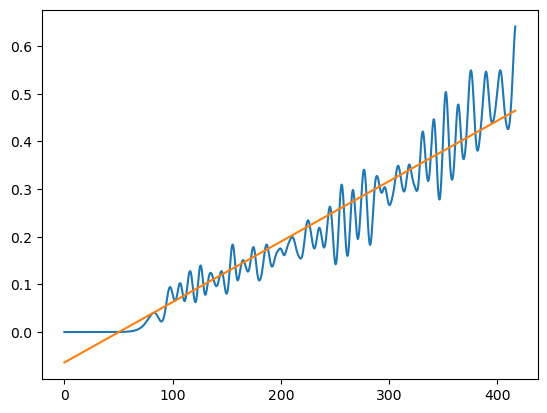

In [10]:
plt.plot(time_s, z_var)
plt.plot(time_s, var_fit(time_s))

In [11]:
ds_tracer = xr.open_dataset("../data/raw_output/shear_instability_state_Ri=0.1.nc")
display(ds_tracer)

<xarray.Dataset> Size: 23MB
Dimensions:  (zC: 64, zF: 65, xC: 64, yF: 1, xF: 64, yC: 1, time: 139)
Coordinates:
  * zC       (zC) float64 512B -4.922 -4.766 -4.609 -4.453 ... 4.609 4.766 4.922
  * zF       (zF) float64 520B -5.0 -4.844 -4.688 -4.531 ... 4.688 4.844 5.0
  * xC       (xC) float64 512B -4.922 -4.766 -4.609 -4.453 ... 4.609 4.766 4.922
  * yF       (yF) float64 8B 1.0
  * xF       (xF) float64 512B -5.0 -4.844 -4.688 -4.531 ... 4.531 4.688 4.844
  * yC       (yC) float64 8B 1.0
  * time     (time) timedelta64[ns] 1kB 00:00:00 00:00:03 ... 00:06:51 00:06:54
Data variables:
    B        (time, zC, yC, xC) float64 5MB ...
    w        (time, zF, yC, xC) float64 5MB ...
    c        (time, zC, yC, xC) float64 5MB ...
    b        (time, zC, yC, xC) float64 5MB ...
    u        (time, zC, yC, xF) float64 5MB ...
Attributes:
    interval:              3.0
    Ri:                    0.1
    Oceananigans:          This file was generated using Oceananigans v0.91.0
    Julia:                 This file was generated using Julia Version 1.10.2...
    output time interval:  Output was saved every 3 seconds.
    date:                  This file was generated on 2024-11-22T11:05:34.611.
    schedule:              TimeInterval

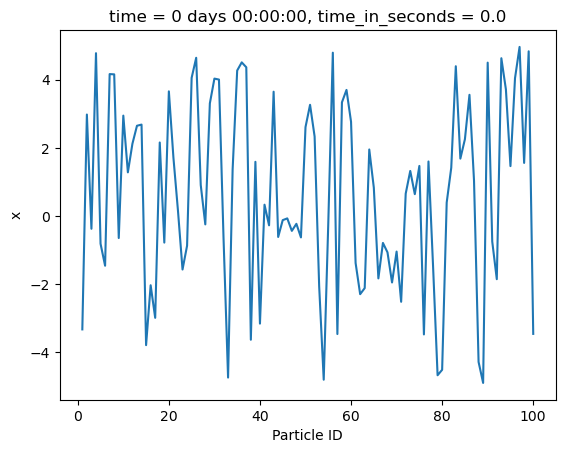

In [12]:
ds.x.isel(time=0).plot()

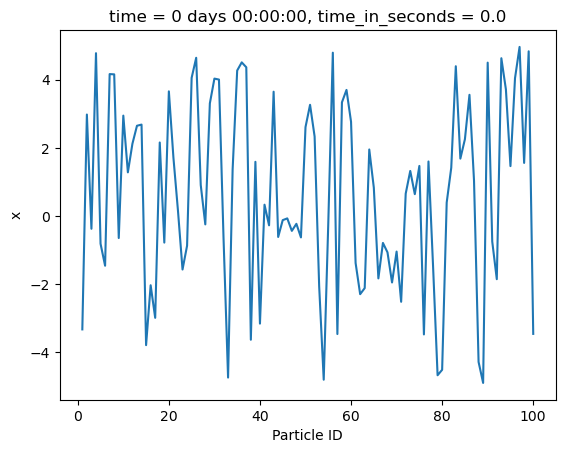

In [13]:
extend_x(ds).x.isel(time=0).plot()

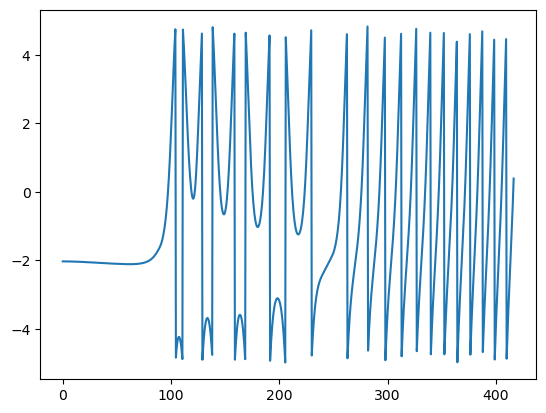

In [14]:
plt.plot(ds.time_in_seconds.values, ds.x.isel(particle_id=15).values)

In [15]:
ds_extended = extend_x(ds)

In [16]:
ds_tracer.c.sel(xC=-2, method="nearest")

<xarray.DataArray 'c' (time: 139, zC: 64, yC: 1)> Size: 71kB
[8896 values with dtype=float64]
Coordinates:
  * zC       (zC) float64 512B -4.922 -4.766 -4.609 -4.453 ... 4.609 4.766 4.922
    xC       float64 8B -1.953
  * yC       (yC) float64 8B 1.0
  * time     (time) timedelta64[ns] 1kB 00:00:00 00:00:03 ... 00:06:51 00:06:54

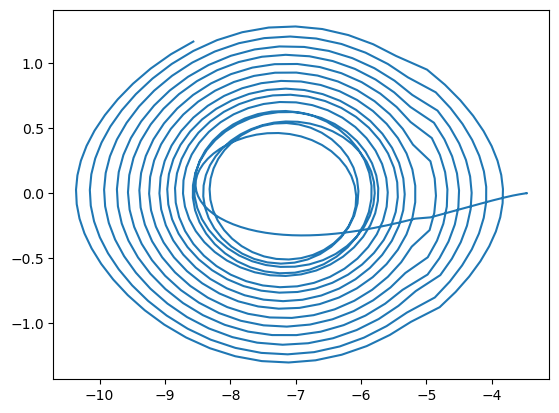

In [17]:
particle = ds_extended.isel(particle_id=99)
plt.plot(
    particle.x,
    particle.z
)

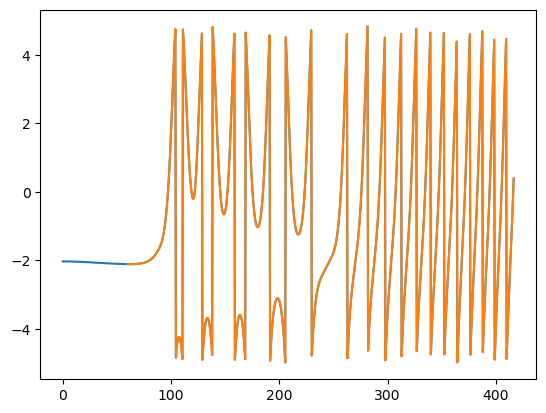

In [18]:
plt.plot(ds.time_in_seconds.values[:], ds.x.values[:,15])
j = 120
plt.plot(ds.time_in_seconds.values[j:len(ds.time_in_seconds)], ds.x.values[j:len(ds.time_in_seconds),15])

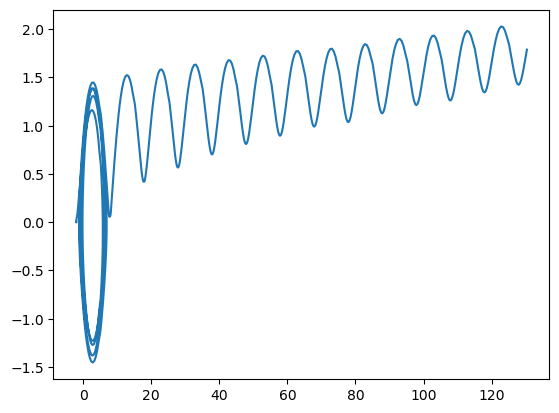

In [19]:
plt.plot(ds_extended.isel(particle_id=15).x, ds_extended.isel(particle_id=15).z)

In [20]:
def extend_x_test(ds):
    """
    Extends the x values of particles once they reach 5 for the purposes of plotting.
        """
    ds_c = ds.copy()
    for i in range(len(ds_c['particle_id'].values)):
        for j in range(1, len(ds_c.time_in_seconds.values)):
            x_cur = ds_c.x.isel(time=j, particle_id=i).values
            x_prev = ds_c.x.isel(time=j-1, particle_id=i).values

            diff = x_cur - x_prev

            if diff > 5:
                ds_c['x'].isel(time=[j], particle_id=[i]).values[0,0] = x_cur - 10
            elif diff < -5:
                ds_c['x'].isel(time =[j], particle_id=[i]).values[0,0] = x_cur + 10

    return ds_c

In [21]:
x_example = ds.x.isel(particle_id=15).values

In [ ]:
for i in range(1, len(x_example)):
    dif = x_example[i]-x_example[i-1]
    print(dif)
    if dif > 5: 
        i_jump = i

In [23]:
i_jump

412

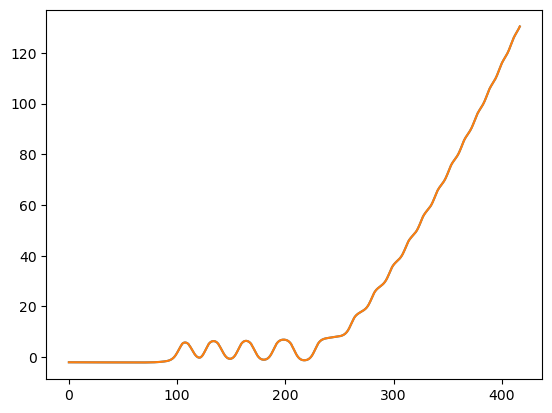

In [24]:
ds_extended = extend_x(ds)
plt.plot(ds.time_in_seconds.values, ds.x.isel(particle_id=15).values)
plt.plot(ds_extended.time_in_seconds.values, ds_extended.x.isel(particle_id=15).values)

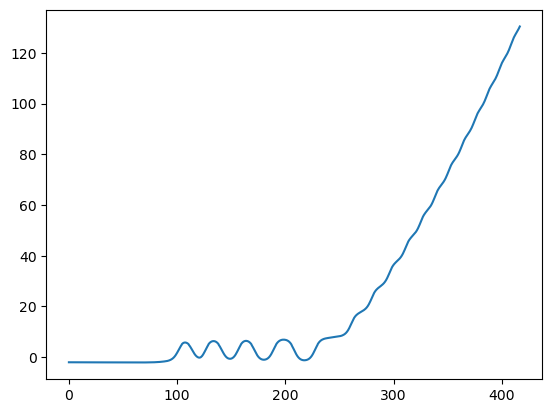

In [25]:
ds_extended = extend_x_test(ds)
plt.plot(ds_extended.time_in_seconds.values, ds_extended.x.isel(particle_id=15).values)

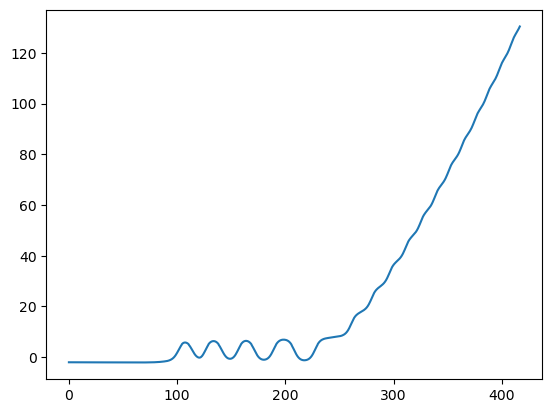

In [26]:
plt.plot(ds.time_in_seconds.values, x_example)


In [27]:
x_example_shifted = np.copy(x_example)
x_example_shifted[i_jump:] = x_example_shifted[i_jump:] - 10

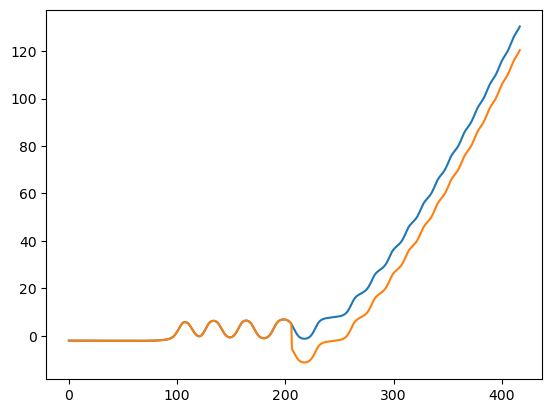

In [28]:
plt.plot(ds.time_in_seconds.values, x_example)
plt.plot(ds.time_in_seconds.values, x_example_shifted)

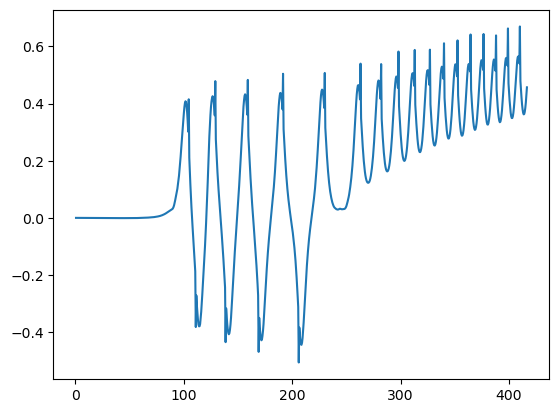

In [29]:
plt.plot(ds.time_in_seconds.values[1:], np.diff(x_example))

In [30]:
len(np.diff(x_example))

833

In [31]:
ds.time_in_seconds

<xarray.DataArray 'time_in_seconds' (time: 834)> Size: 7kB
array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,
        49.5,  50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,
        54. ,  54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,
        58.5,  59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,
        63. ,  63.5,  64. ,  64.5,  65. ,  65.5,  66. ,  66.5,  67. ,
        67.5,  68. ,  68.5,  69. ,  69.5,  70. ,  70.5,  71. ,  71.5,
        72. ,  72.5,  73. ,  73.5,  74. ,  74.5,  75. ,  75.5,  76. ,
        76.5,  77. ,  77.5,  78. ,  78.5,  79. ,  79.5,  80. ,  80.5,
        81. ,  81.5,  82. ,  82.5,  83. ,  83.5,  84. ,  84.5,  85. ,
        85.5,  86. ,  86.5,  87. ,  87.5,  88. ,  88.5,  89. ,  89.5,
...
       328.5, 329. , 329.5, 330. , 330.5, 331. , 331.5, 332. , 332.5,
       333. , 333.5, 334. , 334.5, 335. , 335.5, 336. , 336.5, 337. ,
       337.5, 338. , 338.5, 339. , 339.5, 340. , 340.5, 341. , 341.5,
       342. , 342.5, 343. , 343.5, 344. , 344.5, 345. , 345.5, 346. ,
       346.5, 347. , 347.5, 348. , 348.5, 349. , 349.5, 350. , 350.5,
       351. , 351.5, 352. , 352.5, 353. , 353.5, 354. , 354.5, 355. ,
       355.5, 356. , 356.5, 357. , 357.5, 358. , 358.5, 359. , 359.5,
       360. , 360.5, 361. , 361.5, 362. , 362.5, 363. , 363.5, 364. ,
       364.5, 365. , 365.5, 366. , 366.5, 367. , 367.5, 368. , 368.5,
       369. , 369.5, 370. , 370.5, 371. , 371.5, 372. , 372.5, 373. ,
       373.5, 374. , 374.5, 375. , 375.5, 376. , 376.5, 377. , 377.5,
       378. , 378.5, 379. , 379.5, 380. , 380.5, 381. , 381.5, 382. ,
       382.5, 383. , 383.5, 384. , 384.5, 385. , 385.5, 386. , 386.5,
       387. , 387.5, 388. , 388.5, 389. , 389.5, 390. , 390.5, 391. ,
       391.5, 392. , 392.5, 393. , 393.5, 394. , 394.5, 395. , 395.5,
       396. , 396.5, 397. , 397.5, 398. , 398.5, 399. , 399.5, 400. ,
       400.5, 401. , 401.5, 402. , 402.5, 403. , 403.5, 404. , 404.5,
       405. , 405.5, 406. , 406.5, 407. , 407.5, 408. , 408.5, 409. ,
       409.5, 410. , 410.5, 411. , 411.5, 412. , 412.5, 413. , 413.5,
       414. , 414.5, 415. , 415.5, 416. , 416.5])
Coordinates:
  * time             (time) timedelta64[ns] 7kB 00:00:00 ... 00:06:56.500000
    time_in_seconds  (time) float64 7kB 0.0 0.5 1.0 1.5 ... 415.5 416.0 416.5

In [32]:
import matplotlib.pyplot as plt

In [33]:
ds_extended.x

<xarray.DataArray 'x' (time: 834, particle_id: 100)> Size: 667kB
array([[ -3.328185,   2.97843 ,  -0.374532, ...,   1.558155,   4.834138,
         -3.459849],
       [ -3.32818 ,   2.978434,  -0.374521, ...,   1.558184,   4.834121,
         -3.459837],
       [ -3.328145,   2.978441,  -0.374543, ...,   1.558204,   4.834079,
         -3.459809],
       ...,
       [ -9.60983 ,   3.083024,   2.588254, ...,   3.351874,   1.231655,
         -9.218278],
       [ -9.846944,   3.055496,   2.993113, ...,   3.103615,   1.084289,
         -8.909275],
       [-10.046869,   3.022944,   3.396905, ...,   2.847696,   0.980141,
         -8.565661]])
Coordinates:
  * particle_id      (particle_id) float64 800B 1.0 2.0 3.0 ... 98.0 99.0 100.0
  * time             (time) timedelta64[ns] 7kB 00:00:00 ... 00:06:56.500000
    time_in_seconds  (time) float64 7kB 0.0 0.5 1.0 1.5 ... 415.5 416.0 416.5

In [34]:
ds_extended.x.max("time").idxmax("particle_id")

<xarray.DataArray 'particle_id' ()> Size: 8B
array(53.)

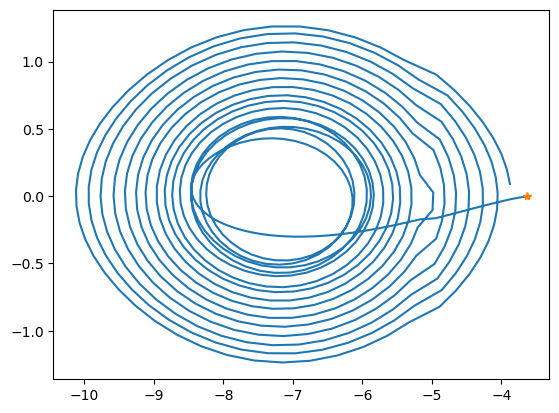

In [35]:
plt.plot(
    ds_extended.x.sel(particle_id=38.),
    ds_extended.z.sel(particle_id=38.),
)
plt.plot(
    ds_extended.x.sel(particle_id=38.).isel(time=0),
    ds_extended.z.sel(particle_id=38.).isel(time=0),
    marker="*"
)

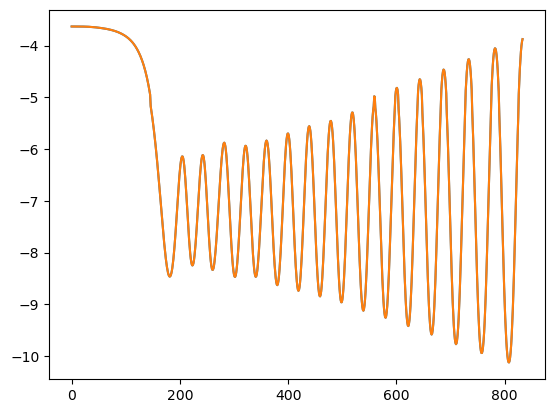

In [36]:
plt.plot(ds_extended.x.sel(particle_id=38.))
plt.plot(ds.x.sel(particle_id=38.))

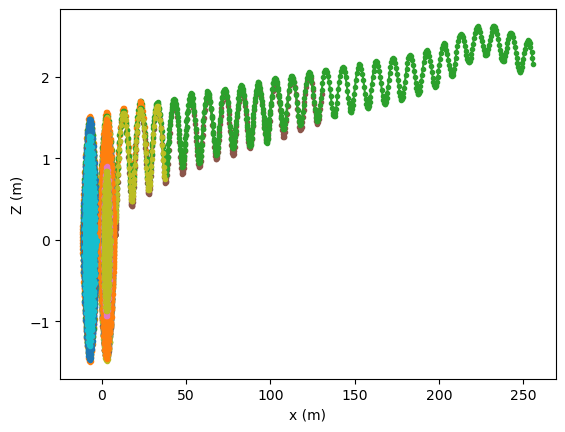

In [37]:
for i,p in enumerate(ds_extended.particle_id):
    plt.plot(
        ds_extended.x.sel(particle_id=p),
        ds_extended.z.sel(particle_id=p),
        ".-"
    );
plt.xlabel("x (m)")
plt.ylabel("Z (m)")
plt.savefig("/Users/rohanvaswani/code/Research Figs/spagetthiextend.png")
#plt.axvline(-5)
#plt.axvline(5)
#plt.xlim(-5, 5)
#FIX: As particle leaves to the right, add length to have particle trajectory be realistic.

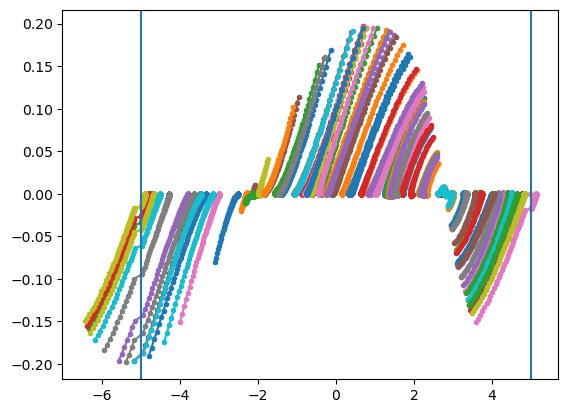

In [38]:
for i,p in enumerate(ds_extended.particle_id):
    plt.plot(
        ds_extended.x.sel(particle_id=p).isel(time=slice(0,150)),
        ds_extended.z.sel(particle_id=p).isel(time=slice(0,150)),
        marker=".",
        linestyle="-",
    );
plt.axvline(-5)
plt.axvline(5)

In [39]:
.isel(time=slice(0,50))

SyntaxError: invalid syntax (512497695.py, line 1)

In [ ]:
ds_extended.x.sel(particle_id=p)

In [ ]:
plt.plot(test_extend.x, test_extend.z);
#FIX: As particle leaves to the right, add length to have particle trajectory be realistic.

In [ ]:
plt.plot(ds.time_in_seconds, ds.z.std("particle_id"))
plt.xlabel("Time (s)")
plt.ylabel(r"$\sigma$")
plt.savefig("/Users/rohanvaswani/code/Research Figs/stdplot.png")

In [ ]:
def particle_stats(arr)



In [ ]:
ds.z_std.plot()

In [632]:
import numpy as np
time_s = ds['time_in_seconds'].values  # Get time values in np array
z_std = ds['z_std'].values 
std_fit = np.polynomial.Polynomial.fit(time_s, z_std, 1) #get 1st order polynomial fit
std_coefs = std_fit.convert().coef
std_slope = std_coefs[1]
k = (std_slope / 2 #vertical turbulent diffusivity in m/s
print(f"The turbulent vertical diffusivity of this simulation is {np.round(k,5)} meters per second")

The turbulent vertical diffusivity of this simulation is 0.00181 meters per second


In [608]:
help(np.polynomial.Polynomial.fit)
type(ds.time.values[1])

Help on method fit in module numpy.polynomial._polybase:

fit(x, y, deg, domain=None, rcond=None, full=False, w=None, window=None, symbol='x') method of abc.ABCMeta instance
    Least squares fit to data.
    
    Return a series instance that is the least squares fit to the data
    `y` sampled at `x`. The domain of the returned instance can be
    specified and this will often result in a superior fit with less
    chance of ill conditioning.
    
    Parameters
    ----------
    x : array_like, shape (M,)
        x-coordinates of the M sample points ``(x[i], y[i])``.
    y : array_like, shape (M,)
        y-coordinates of the M sample points ``(x[i], y[i])``.
    deg : int or 1-D array_like
        Degree(s) of the fitting polynomials. If `deg` is a single integer
        all terms up to and including the `deg`'th term are included in the
        fit. For NumPy versions >= 1.11.0 a list of integers specifying the
        degrees of the terms to include may be used instead.
    doma

numpy.timedelta64

In [ ]:
ds.close()